## Collaborative filtering
How a user would rate an unseen movie is predicted based on how similar users have rated similar movies. The model used here is non-negative matrix factorization, since it manages sparsity well (the user-movie rating matrix will be sparse since most users will only watch a small subset of movies in the database)

In [82]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import joblib
%matplotlib inline

### Importing data
... and exploring the tables. Note that a projection of metadata is imported.

In [2]:
ratings = pd.read_csv('../ratings_small.csv')
links = pd.read_csv('../links_small.csv')
metadata = pd.read_csv('../movies_metadata.csv')[['id', 'title']].set_index('id')
ratings.head()

/usr/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3050: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


The links table maps movieId to imdbId and tmdbId. This is important because, for instance, the metadata table uses tmdbId to identify movies whereas the ratings table uses movieId. <br> 
The links table is made more managable by doing the following:<br>
- Since 'tmbdId' contains NaN entries, all values are treated as np.float; that is fixed (since id should definitely be considered as int)
- movieId is set as index

In [3]:
links['id'] = links['tmdbId'].apply(lambda x: int(x) if not np.isnan(x) else -1)
links = links[['movieId', 'id']].set_index('movieId')
links.head()

,id
movieId,
1,862
2,8844
3,15602
4,31357
5,11862


In [5]:
metadata.head()

,title
id,
862,Toy Story
8844,Jumanji
15602,Grumpier Old Men
31357,Waiting to Exhale
11862,Father of the Bride Part II


## Building our model

Some data structures useful for computing preference matrices are generated:
- 'users' is a pd.Series of userIds
- 'movies' is a pd.Series of movieIds
- 'movieId_map' maps a list of 0-based indices to movieIds. This is done because movieIds are not consecutive, which is problematic when referring to columns in preference matrix by movieId. Thus movieId is mapped to an index which can be used to select column from matrix
- 'userId_map' maps a list of 0-based indices to userIds
- 'inv_movieId_map' inverts the movieId_map mapping. This is useful when we need to infer rating from preference matrix.
- 'inv_userId_map' inverts the userId_map mapping.

In [15]:
users = ratings['userId'].unique()
movies = ratings['movieId'].unique()
movieId_map = pd.Series(np.arange(len(movies)), index = movies)
userId_map = pd.Series(np.arange(len(users)), index = users)

In [30]:
inv_movieId_map = pd.Series(movies, index = np.arange(len(movies)))
inv_userId_map = pd.Series(users, index = np.arange(len(users)))

In [31]:
inv_movieId_map

0          31
1        1029
2        1061
3        1129
4        1172
        ...  
9061    64997
9062    72380
9063      129
9064     4736
9065     6425
Length: 9066, dtype: int64

### Preference matrix
Preference matrix based on available information is generated. Matrix has mapped userIds as rows and mapped userIds as columns. Entry (i, j) is the rating user i has given to movie j. If user i has not seen movie j, entry (i, j) = 0

In [18]:
preference_matrix = np.zeros(shape = (userId_map.shape[0], movieId_map.shape[0]), dtype = np.float16)
for index, movie in ratings.iterrows():
    preference_matrix[userId_map[movie[0]], movieId_map[movie[1]]] = movie['rating']

### Recomputed preference matrix
Preference matrix P is approximately factorized into matrices W and H. 
- W has dimension n_users x number of latent features. It describes how a user rates a set of latent features that describe movies.
- H has dimension number of latent features x n_movies. It describes how latent features describe each movie.
- Number of latent features has been chosen as 30 due to computational limitations. Ideally, the number would be much higher, selected via GridSearchCV.

In [21]:
model = NMF(n_components = 30, init = 'random', random_state = 0)
users_latent_feat = model.fit_transform(preference_matrix)
latent_feat_movies = model.components_

As a result of approximation, when preferences are re-computed from product of W and H, most zeroes in the matrix are changed to non-zeroes.

In [22]:
modified_preferences = np.dot(users_latent_feat, latent_feat_movies)

In [60]:
def get_recommendations(userId):
    user_pref = modified_preferences[inv_userId_map[userId], :].reshape(modified_preferences.shape[1])
    user_pref = list(enumerate(user_pref))
    user_pref = sorted(user_pref, key = lambda x: x[1], reverse = True)[:50]
    preferences = []
    for i in user_pref:
        Id = inv_movieId_map[i[0]]
        Id = links.loc[Id].values[0]
        title = metadata.loc[str(Id)].values[0]
        preferences.append(title)       
    return preferences

Let's see what movies user '2' is recommended by the model:

In [62]:
get_recommendations(2)

['The Empire Strikes Back',
 'Return of the Jedi',
 'Star Wars',
 'Back to the Future',
 'The Terminator',
 'Men in Black',
 'Raiders of the Lost Ark',
 'Terminator 2: Judgment Day',
 'E.T. the Extra-Terrestrial',
 'Aliens',
 'Alien',
 'Blade Runner',
 'The Princess Bride',
 'Indiana Jones and the Last Crusade',
 'Star Wars: Episode I - The Phantom Menace',
 'Monty Python and the Holy Grail',
 'Total Recall',
 'Die Hard',
 'Star Trek IV: The Voyage Home',
 'Star Trek II: The Wrath of Khan',
 'The Blues Brothers',
 'Jurassic Park',
 'Forrest Gump',
 'Groundhog Day',
 'Big',
 'Beetlejuice',
 'Ghostbusters',
 'Superman',
 'The Matrix',
 "Ferris Bueller's Day Off",
 'The Abyss',
 'Who Framed Roger Rabbit',
 'Lethal Weapon',
 'Jaws',
 'Indiana Jones and the Temple of Doom',
 'Back to the Future Part II',
 'The Breakfast Club',
 'Aladdin',
 'Full Metal Jacket',
 'Stand by Me',
 'When Harry Met Sally...',
 'Contact',
 'The Wizard of Oz',
 'Willy Wonka & the Chocolate Factory',
 'The Fifth Ele

This is looks good, since most movies are very similar. The user seems to have a preference for Star Wars movies, and we see that Star Trek and many other sci-fi titles have been recommended. Storing the modified preferences matrix and mappings using this model's name ('third'):

In [86]:
joblib.dump(modified_preferences, '../THIRD-modified_preferences', compress = 9)
joblib.dump(movieId_map, '../THIRD-movieId_map', compress = 9)
joblib.dump(userId_map, '../THIRD-userId_map', compress = 9)
joblib.dump(inv_movieId_map, '../THIRD-inv_movieId_map', compress = 9)
joblib.dump(inv_userId_map, '../THIRD-inv_userId_map', compress = 9)

['../THIRD-inv_userId_map']

## Visualizing the results
First, we look at how ratings are distributed in the original preference matrix. Setting a very low value of alpha, we see that the more solid a region, more number of ratings exist for that value.

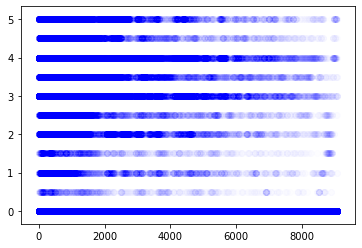

In [84]:
for user_ratings in preference_matrix:
    plt.scatter(np.arange(modified_preferences.shape[1]), user_ratings, c = 'b', alpha = 0.007)
plt.show()

In the original matrix, rating = 0 is the most dense region of the graph, meaning that the matrix is very sparse. Furthermore, we see that as we move down the list of users, information about their preferences becomes very sparse. Now, performing the same visualization for the modified preference matrix:

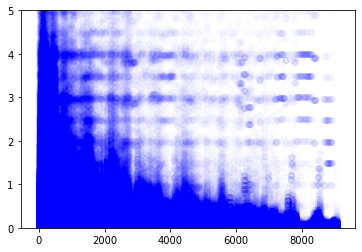

In [85]:
for user_ratings in modified_preferences:
    plt.scatter(np.arange(modified_preferences.shape[1]), user_ratings, c = 'b', alpha = 0.007)
plt.ylim((0,5))
plt.show()

In this case, we see that other regions also become dense, hence reducing the sparcity of the matrix. Thus more information about user preferences is now available. However, since the original matrix became sparser on moving down the list of users, the modified matrix too exhibits this behaviour, albeit to a lesser extent. <br><br>
In conclusion, the modified preference matrix holds a lot of predictive power about what movie's a user would like based on the collaborative filtering approach.